# Basic CNN Model for MNIST dataset

---

MINEによって，layer間の相互情報量(MI; Mututla Information)を測る．そのために，学習済みモデルを用意しておく．

In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pycuda.driver as cuda

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [2]:
use_cuda = torch.cuda.is_available()
print("Setting Info")
print("===========")
print("- use_cuda: ", use_cuda)
print("- Path: ", os.getcwd())
print("- PyTorch", torch.__version__)
print("- Python: ", sys.version)

Setting Info
- use_cuda:  True
- Path:  /home/uchiumi/JNNS2019/mnist_pytorch
- PyTorch 1.0.1.post2
- Python:  3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]


## Meta settings

In [3]:
n_epochs = 10
batch_size_train = 128
batch_size_test = 1000
log_interval = 100

# 
random_seed = 1
torch.backends.cudnn.enabled = False

## Data loader

In [4]:
# train
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', 
                             train=True, 
                             download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

In [5]:
# test
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data', 
                             train=False, 
                             download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

test

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
example_data.shape

torch.Size([1000, 1, 28, 28])

## Building the Network

In [8]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        layer_values={}
        layer_values["input_image"]=x
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        layer_values["conv1_output"]=x
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        layer_values["conv2_output"]=x
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        layer_values["fc1_output"]=x
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        layer_values["fc2_output"]=x
        x = F.log_softmax(x)
        layer_values["output_softmax"]=x
        
        return layer_values

## Training

In [9]:
# model name
date_string = datetime.now().strftime("%Y-%m%d-%H%M")
model_name = "model__" + date_string
optim_name = "optim__" + date_string

In [10]:
# variables for log plot
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(1, n_epochs+1)]

In [11]:
def model_fit(model, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)["output_softmax"]
        train_loss = F.nll_loss(output, target)
        train_loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0 and batch_idx != 0:
            print('epoch: {} [{}/{} ]\t train loss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), train_loss.item()))
            
            train_losses.append(train_loss.item())
            train_counter.append((batch_idx * batch_size_train) + ((epoch - 1)*len(train_loader.dataset)))
            
            model_path = os.path.join(os.getcwd(), "train_log", model_name + ".pth")
            optim_path = os.path.join(os.getcwd(), "train_log", optim_name + ".pth")
            torch.save(model.state_dict(), model_path)
            torch.save(optimizer.state_dict(), optim_path)

In [12]:
def model_validation(model):
    model.eval()
    test_loss = 0
    nb_correct = 0
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            output = model(data)["output_softmax"]
            test_loss += F.nll_loss(output, target, size_average=False).item()
            test_batch_loss = F.nll_loss(output, target, size_average=False).item() / batch_size_test
            # test_loss /= len(test_loader.dataset)
            # test_losses.append(test_loss)
            pred = output.data.max(1, keepdim=True)[1]
            nb_correct += pred.eq(target.data.view_as(pred)).sum()
            print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{}'.format(test_batch_loss, nb_correct, batch_size_test * (batch_idx + 1)))
    
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

## Run

In [13]:
model = Network()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [14]:
for epoch in range(1, n_epochs + 1):
    model_fit(model, optimizer, epoch)
    model_validation(model)

/home/uchiumi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


epoch: 1 [12800/60000 ]	 train loss: 1.866613
epoch: 1 [25600/60000 ]	 train loss: 1.386251
epoch: 1 [38400/60000 ]	 train loss: 0.995102
epoch: 1 [51200/60000 ]	 train loss: 0.669444


/home/uchiumi/.local/lib/python3.5/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: 0.3301, Accuracy: 909/1000
Test set: Avg. loss: 0.3248, Accuracy: 1820/2000
Test set: Avg. loss: 0.2887, Accuracy: 2746/3000
Test set: Avg. loss: 0.3275, Accuracy: 3659/4000
Test set: Avg. loss: 0.3131, Accuracy: 4572/5000
Test set: Avg. loss: 0.3426, Accuracy: 5490/6000
Test set: Avg. loss: 0.3370, Accuracy: 6395/7000
Test set: Avg. loss: 0.3334, Accuracy: 7303/8000
Test set: Avg. loss: 0.2982, Accuracy: 8230/9000
Test set: Avg. loss: 0.3154, Accuracy: 9148/10000
epoch: 2 [12800/60000 ]	 train loss: 0.545189
epoch: 2 [25600/60000 ]	 train loss: 0.419351
epoch: 2 [38400/60000 ]	 train loss: 0.579557
epoch: 2 [51200/60000 ]	 train loss: 0.395925
Test set: Avg. loss: 0.1890, Accuracy: 943/1000
Test set: Avg. loss: 0.1807, Accuracy: 1895/2000
Test set: Avg. loss: 0.1737, Accuracy: 2845/3000
Test set: Avg. loss: 0.1782, Accuracy: 3794/4000
Test set: Avg. loss: 0.1587, Accuracy: 4757/5000
Test set: Avg. loss: 0.1674, Accuracy: 5707/6000
Test set: Avg. loss: 0.1608, Accu

## Evaluating the Model's Performance

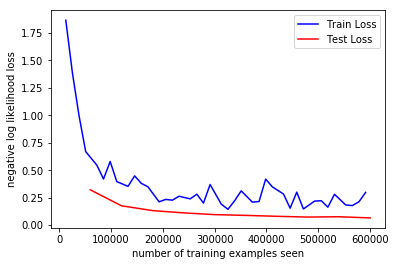

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()